# IPL Auction 2025 - Web Scraping & Data Analysis
## CodeAlpha Data Analytics Internship - Task 1
### Author: Simitha Ummer
### Date: November 2025

Task Overview:
-----------------
This work demonstrates web scraping techniques by extracting IPL 2025 auction data, cleaning it, validating data quality, and performing analysis on team spending patterns.

### Objectives:
- Scrape player auction data (names, teams, bids)
- Clean and process the data
- Analyze team spending patterns
- Create visualizations


### Step 1: Import Required Libraries

In [1]:
# Core Python libraries
import requests              # For making HTTP requests to websites
from bs4 import BeautifulSoup  # For parsing HTML content
import os                    # For file and directory operations
import re                    # For pattern matching (regex)
import csv                   # For CSV file operations
import json                  # For JSON file operations
import warnings              # For controlling warning messages

# Data analysis and visualization
import pandas as pd          # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating visualizations

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


### Step 2: Define URL & Headers (Mimic a Browser Request)

In [2]:
# Base URL for IPL Auction 2025 Official Page
url = "https://www.iplt20.com/auction/2025"

# Headers: Pretend like we are a real browser to avoid being blocked
headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept-Language": "en-US,en;q=0.9"
}

# Output directory and file paths
OUT_DIR = "data"
OUT_CSV = os.path.join(OUT_DIR, "ipl_auction_2025_players.csv")
OUT_CSV_CLEANED = os.path.join(OUT_DIR, "ipl_auction_2025_players_cleaned.csv")  # Cleaned CSV
OUT_SUMMARY = os.path.join(OUT_DIR, "ipl_auction_2025_summary.json")

print(f"Data will be saved to: {OUT_DIR}")
print(f"CSV file: {OUT_CSV}")
print(f"Cleaned CSV File: {OUT_CSV_CLEANED}")
print(f"Summary file: {OUT_SUMMARY}")

Data will be saved to: data
CSV file: data\ipl_auction_2025_players.csv
Cleaned CSV File: data\ipl_auction_2025_players_cleaned.csv
Summary file: data\ipl_auction_2025_summary.json


### Step 3: 
#### a) Define Helper Function- Fetch HTML

Fetch HTML content from a given URL.

Args: url (str): Website URL to fetch

Returns: str: HTML content as text

Raises: requests.HTTPError: If request fails

In [3]:
def fetch_html(url):
    response = requests.get(url, headers=headers, timeout=20)    # Make GET request with headers and timeout      
    response.raise_for_status()      # Raise exception if request failed 
    return response.text       # Return HTML content

#### b) Define Helper Function - Convert Money Strings
Convert money strings to integer INR ('₹ 27 cr' -> 270000000)

Args: money_text (str): Money string in various formats
        
Returns: int or None: Amount in rupees or None if invalid

In [4]:
def money_to_int(money_text):
    if not money_text:         # Handle empty or None values
        return None
        
    s = str(money_text).strip()     # Convert to string and remove whitespace
    
    if s in ["—", "-", "RTM", "RTM "]:    # Handle special characters for "not sold" or "retained"
        return None
        
    match = re.search(r'([\d,.]+)\s*cr', s, flags=re.I)   # Check if format contains 'cr' (crores)
    if match: 
        num = match.group(1).replace(",", "")     # Extract number part and remove commas
        try:
            return int(float(num) * 10000000)    # Convert crores to rupees (1 crore = 10,000,000)
        except:
            return None
    
    s2 = re.sub(r'[^\d,]', '', s)         # Remove all non-digit characters except commas

    s2 = s2.replace(",", "")     # Remove commas
    
    if s2 == "":     # Return None if empty
        return None
        
    try:         # Try to convert to integer
        return int(s2)
    except:
        return None

#### c) Define Helper Function - Parse HTML Tables
Parse HTML tables containing player auction data.

Process:

    1. Find all tables in the HTML
    2. Identify auction tables by checking headers
    3. Extract team name from nearest heading
    4. Parse each player row
    
Args: soup(BeautifulSoup): Parsed HTML document
        
Returns: list: List of dictionaries with player records with team, name, prices, etc

In [5]:
def parse_tables(soup):
    
    results = []     # List to store all player records
    
    tables = soup.find_all("table")   # Find all table elements in the HTML
    
    for table in tables:      # Loop through each table
        
        headers = [th.get_text(" ", strip=True).lower() for th in table.find_all("th")]    # Extract header text from table headers (th tags)
        
        header_blob = " ".join(headers)     # Combine all headers into one string for checking
        
        # Check if this is an auction table
        is_auction_table = (
            "player" in header_blob and
            ("base price" in header_blob or "baseprice" in header_blob) and
            ("winning bid" in header_blob or "winningbid" in header_blob)
        )
        
        if is_auction_table:
            # Find team name from previous heading
            team_tag = table.find_previous(
                lambda tag: tag.name in ("h1","h2","h3","h4") 
                and tag.get_text(strip=True)
            )
            team_name = team_tag.get_text(" ", strip=True) if team_tag else "Unknown Team"
            
            for tr in table.select("tbody > tr"):     # Parse each row in the table body
                cols = [td.get_text(" ", strip=True) for td in tr.find_all(["td","th"])]     # Extract all cell values (both td and th tags)
            
                if not cols:   # Skip empty rows
                    continue
                
                # Extract data from columns (with safe indexing)
                sr_no = cols[0] if len(cols) > 0 else ""
                player = cols[1] if len(cols) > 1 else ""       # Typical structure: Sr. No., Player, Base Price, Winning Bid, Capped/Uncapped
                base_price = cols[2] if len(cols) > 2 else ""
                winning_bid = cols[3] if len(cols) > 3 else ""
                capped = cols[4] if len(cols) > 4 else ""
                
                # Create player record dictionary
                results.append({
                    "team": team_name,
                    "sr_no": sr_no,
                    "player": player,
                    "base_price_raw": base_price,
                    "winning_bid_raw": winning_bid,
                    "capped_status": capped
                })
    
    return results

#### d) Define Helper Function - Extract Summary
Extract summary information (most expensive player, total spent).

Args: soup (BeautifulSoup): Parsed HTML document
        
Returns: dict: Summary information

In [6]:
def extract_summary(soup):
    
    summary = {}
    
    m = soup.find(text=re.compile(r"Most Expensive Player", re.I))       # Look for "Most Expensive Player" text
    if m:
        try:
            # Find next sibling element with player info
            p_tag = m.parent.find_next(lambda tag: tag.name in ("h2","h3","h4","div","span") and tag.get_text(strip=True))
            if p_tag:
                summary["most_expensive_block"] = p_tag.get_text(" ", strip=True)
        except:
            pass
    
    spent_tag = soup.find(text=re.compile(r"Spent", re.I))     # Look for "Spent" or "Total" text
    if spent_tag:
        try:
            summary["total_spent_text"] = spent_tag.parent.get_text(" ", strip=True)
        except:
            summary["total_spent_text"] = str(spent_tag)
    
    rupee_like = soup.find(text=re.compile(r'₹\s*[\d,]+|cr', re.I))       # Fallback: search for rupee symbols and 'cr' text
    if rupee_like and "total_spent_text" not in summary:
        summary["sample_money_text"] = rupee_like.strip()
    
    return summary

### Step 4: Main Scraping Function
Steps:

    1. Create output directory
    2. Fetch HTML from website
    3. Parse tables to extract player data
    4. Convert money values to integers
    5. Save data to CSV
    6. Extract and save summary to JSON

In [7]:
def main():
    os.makedirs(OUT_DIR, exist_ok=True)    # Create output directory if it doesn't exist
    print(f"Output directory ready: {OUT_DIR}\n")
    
    print(f"Fetching data from: {url}\n")    # Fetch HTML content
    html = fetch_html(url)
    print("HTML content retrieved successfully!")
    
    print("Parsing HTML with BeautifulSoup...\n")     # Parse HTML using BeautifulSoup
    soup = BeautifulSoup(html, "lxml")
    print("HTML parsed with BeautifulSoup\n")
    
    print("Parsing tables...")       # Extract player data from tables
    rows = parse_tables(soup)
    print(f"Found {len(rows)} player records\n")
    
    print("Converting money values...")     # Convert money strings to integers
    for r in rows:
        r["base_price_inr"] = money_to_int(r.get("base_price_raw"))
        r["winning_bid_inr"] = money_to_int(r.get("winning_bid_raw"))
    print("Money values converted\n")
        
    print(f"Saving raw data to CSV: {OUT_CSV}")       # Save to CSV
    fieldnames = ["team", "sr_no", "player", "base_price_raw", "base_price_inr", 
              "winning_bid_raw", "winning_bid_inr", "capped_status"]
    
    with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for r in rows:
            out = {k: r.get(k, "") for k in fieldnames}
            writer.writerow(out)
    print(f"Raw CSV saved: {OUT_CSV}\n")
    
    print(f"Extracting summary...")     # Extract and save summary
    summary = extract_summary(soup)
    with open(OUT_SUMMARY, "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2)
    print(f"Summary saved: {OUT_SUMMARY}\n")

if __name__ == "__main__":
    main()
print("=" * 70)
print("WEB SCRAPING COMPLETED SUCCESSFULLY!")
print("=" * 70)

Output directory ready: data

Fetching data from: https://www.iplt20.com/auction/2025

HTML content retrieved successfully!
Parsing HTML with BeautifulSoup...

HTML parsed with BeautifulSoup

Parsing tables...
Found 202 player records

Converting money values...
Money values converted

Saving raw data to CSV: data\ipl_auction_2025_players.csv
Raw CSV saved: data\ipl_auction_2025_players.csv

Extracting summary...
Summary saved: data\ipl_auction_2025_summary.json

WEB SCRAPING COMPLETED SUCCESSFULLY!


## Data Analysis - Load Data
Now that we have scraped the data, let's analyze it using Pandas.

In [8]:
df = pd.read_csv(OUT_CSV)   # Load the CSV file into a DataFrame

print("\n RAW DATA OVERVIEW")
print("=" * 70)
print(f"Total Records: {len(df)}")
print(f"Columns: {', '.join(df.columns)}")
print("\n First 5 Records:")
print(df.head())
print("\n Data Info:")
print(df.info())


 RAW DATA OVERVIEW
Total Records: 202
Columns: team, sr_no, player, base_price_raw, base_price_inr, winning_bid_raw, winning_bid_inr, capped_status

 First 5 Records:
                  team  sr_no                player base_price_raw  \
0  Chennai Super Kings    1.0            Noor Ahmad    2,00,00,000   
1  Chennai Super Kings    2.0  Ravichandaran Ashwin    2,00,00,000   
2  Chennai Super Kings    3.0          Devon Conway    2,00,00,000   
3  Chennai Super Kings    4.0    Syed Khaleel Ahmed    2,00,00,000   
4  Chennai Super Kings    5.0       Rachin Ravindra    1,50,00,000   

   base_price_inr winning_bid_raw  winning_bid_inr capped_status  
0        20000000    10,00,00,000        100000000        Capped  
1        20000000     9,75,00,000         97500000        Capped  
2        20000000     6,25,00,000         62500000        Capped  
3        20000000     4,80,00,000         48000000        Capped  
4        15000000     4,00,00,000         40000000        Capped  

 Data In

### Data Quality Check & Cleaning
Data Quality Validation:
1. Check for duplicate players
2. Check for null values
3. Validate data consistency
4. Clean the dataset

In [9]:
print("\n" + "=" * 70)
print("DATA QUALITY VALIDATION")
print("=" * 70)

# Check 1: Duplicate Players
print("\n1️. CHECKING FOR DUPLICATE PLAYERS")
print("-" * 70)

# Count duplicates
duplicate_count = df.duplicated(subset=['player']).sum()
print(f"Total duplicate entries found: {duplicate_count}")

if duplicate_count > 0:
    # Show duplicate entries
    duplicates = df[df.duplicated(subset=['player'], keep=False)].sort_values('player')
    print(f"\nWARNING: Found {len(duplicates)} duplicate player entries!\n")
    print("Duplicate Players Details:")
    print(duplicates[['team', 'player', 'winning_bid_raw', 'winning_bid_inr']])
    
    # Analyze duplicates
    duplicate_players = duplicates['player'].unique()
    print(f"\nUnique players with duplicates: {len(duplicate_players)}")
    for player in duplicate_players[:5]:  # Show first 5
        player_records = duplicates[duplicates['player'] == player]
        print(f"\n • {player}:")
        print(f"Teams: {', '.join(player_records['team'].values)}")
        print(f"Bids: {', '.join(player_records['winning_bid_raw'].values)}")
    
    # Remove duplicates (keep first occurrence)
    print(f"\nCLEANING: Removing duplicates (keeping first occurrence)...")
    df_cleaned = df.drop_duplicates(subset=['player'], keep='first')
    print(f"Duplicates removed!")
    print(f"Before: {len(df)} records")
    print(f"After:  {len(df_cleaned)} records")
    print(f"Removed: {len(df) - len(df_cleaned)} duplicate entries")
else:
    print("No duplicate players found - Data is clean!")
    df_cleaned = df.copy()

# Check 2: Null Values
print("\n2️. CHECKING FOR NULL VALUES")
print("-" * 70)
null_counts = df_cleaned[['player', 'team', 'winning_bid_inr']].isnull().sum()
print(null_counts)

if null_counts.sum() > 0:
    print("\nFound null values in important columns")
else:
    print("No null values in critical columns")

# Check 3: Data Consistency
print("\n3️. DATA CONSISTENCY CHECK")
print("-" * 70)
print(f"Players with valid bids: {df_cleaned['winning_bid_inr'].notna().sum()}")
print(f"Players without bids (unsold/retained): {df_cleaned['winning_bid_inr'].isna().sum()}")
print(f"Unique teams: {df_cleaned['team'].nunique()}")
print(f"Unique players: {df_cleaned['player'].nunique()}")

# Save cleaned data
print(f"\nSAVING CLEANED DATA")
print("-" * 70)
df_cleaned.to_csv(OUT_CSV_CLEANED, index=False)
print(f"Cleaned data saved to: {OUT_CSV_CLEANED}")

# Update working dataframe
df = df_cleaned.copy()

print("\n" + "=" * 70)
print("DATA CLEANING COMPLETED!")
print("=" * 70)


DATA QUALITY VALIDATION

1️. CHECKING FOR DUPLICATE PLAYERS
----------------------------------------------------------------------
Total duplicate entries found: 20


Duplicate Players Details:
                            team             player winning_bid_raw  \
185          Sunrisers Hyderabad     Arshdeep Singh   ₹18,00,00,000   
113                 Punjab Kings     Arshdeep Singh    18,00,00,000   
200          Sunrisers Hyderabad  Bhuvneshwar Kumar   ₹10,75,00,000   
151  Royal Challengers Bengaluru  Bhuvneshwar Kumar    10,75,00,000   
195          Sunrisers Hyderabad       Ishan Kishan   ₹11,25,00,000   
167          Sunrisers Hyderabad       Ishan Kishan    11,25,00,000   
197          Sunrisers Hyderabad      Jitesh Sharma   ₹11,00,00,000   
150  Royal Challengers Bengaluru      Jitesh Sharma    11,00,00,000   
134             Rajasthan Royals       Jofra Archer    12,50,00,000   
190          Sunrisers Hyderabad       Jofra Archer   ₹12,50,00,000   
39                Gujara

### 1) Top 10 Most Expensive Players
Identify which players commanded the highest bids.

In [10]:
# Filter out players without winning bids and remove any remaining duplicates
top_buys = (df.dropna(subset=["winning_bid_inr"])  # Remove null values
           .drop_duplicates(subset=['player'], keep='first')  # Ensure no duplicates
           .sort_values("winning_bid_inr", ascending=False)  # Sort descending
           .head(10))  # Get top 10

print("\nTOP 10 MOST EXPENSIVE PLAYERS (UNIQUE)")
print("=" * 70)
print(top_buys[["team", "player", "winning_bid_raw", "winning_bid_inr"]])

# Show more details
print("\nDetailed View:")
for idx, row in top_buys.iterrows():
    print(f"\n{list(top_buys.index).index(idx) + 1}. {row['player']}")
    print(f"Team: {row['team']}")
    print(f"Winning Bid: {row['winning_bid_raw']}")
    print(f"Base Price: {row['base_price_raw']}")
    print(f"Status: {row['capped_status']}")


TOP 10 MOST EXPENSIVE PLAYERS (UNIQUE)
                            team            player winning_bid_raw  \
74          Lucknow Super Giants      Rishabh Pant    27,00,00,000   
111                 Punjab Kings      Shreyas Iyer    26,75,00,000   
59         Kolkata Knight Riders    Venkatesh Iyer    23,75,00,000   
112                 Punjab Kings  Yuzvendra Chahal    18,00,00,000   
113                 Punjab Kings    Arshdeep Singh    18,00,00,000   
39                Gujarat Titans      Jos  Buttler    15,75,00,000   
20                Delhi Capitals          KL Rahul    14,00,00,000   
148  Royal Challengers Bengaluru    Josh Hazlewood    12,50,00,000   
93                Mumbai Indians       Trent Boult    12,50,00,000   
134             Rajasthan Royals      Jofra Archer    12,50,00,000   

     winning_bid_inr  
74         270000000  
111        267500000  
59         237500000  
112        180000000  
113        180000000  
39         157500000  
20         140000000  
148  

### 2) Team-wise Total Spending
Calculate how much each team spent in the auction.

In [11]:
# Group by team and sum the winning bids
team_spend = (df.groupby("team")["winning_bid_inr"]  # Group by team
             .sum()  # Sum all winning bids
             .sort_values(ascending=False))  # Sort highest to lowest

print("\nTEAM-WISE TOTAL SPENDING")
print("=" * 70)
print("\nSpending in INR:")
print(team_spend)

# Convert to crores for readability
print("\nTEAM-WISE TOTAL SPENDING (in Crores)")
print("=" * 70)
team_spend_crores = team_spend / 1e7
for team, spend in team_spend_crores.items():
    print(f"{team:30s}: ₹{spend:,.2f} Crores")


TEAM-WISE TOTAL SPENDING

Spending in INR:
team
Punjab Kings                   1101500000
Royal Challengers Bengaluru     822500000
Delhi Capitals                  728000000
Lucknow Super Giants            689000000
Gujarat Titans                  688500000
Chennai Super Kings             549500000
Kolkata Knight Riders           509500000
Mumbai Indians                  448000000
Sunrisers Hyderabad             448000000
Rajasthan Royals                407000000
Name: winning_bid_inr, dtype: int64

TEAM-WISE TOTAL SPENDING (in Crores)
Punjab Kings                  : ₹110.15 Crores
Royal Challengers Bengaluru   : ₹82.25 Crores
Delhi Capitals                : ₹72.80 Crores
Lucknow Super Giants          : ₹68.90 Crores
Gujarat Titans                : ₹68.85 Crores
Chennai Super Kings           : ₹54.95 Crores
Kolkata Knight Riders         : ₹50.95 Crores
Mumbai Indians                : ₹44.80 Crores
Sunrisers Hyderabad           : ₹44.80 Crores
Rajasthan Royals              : ₹40.70 Cro

### Data Visualization: Team Spending Bar Chart
Create a visual representation of team spending patterns.

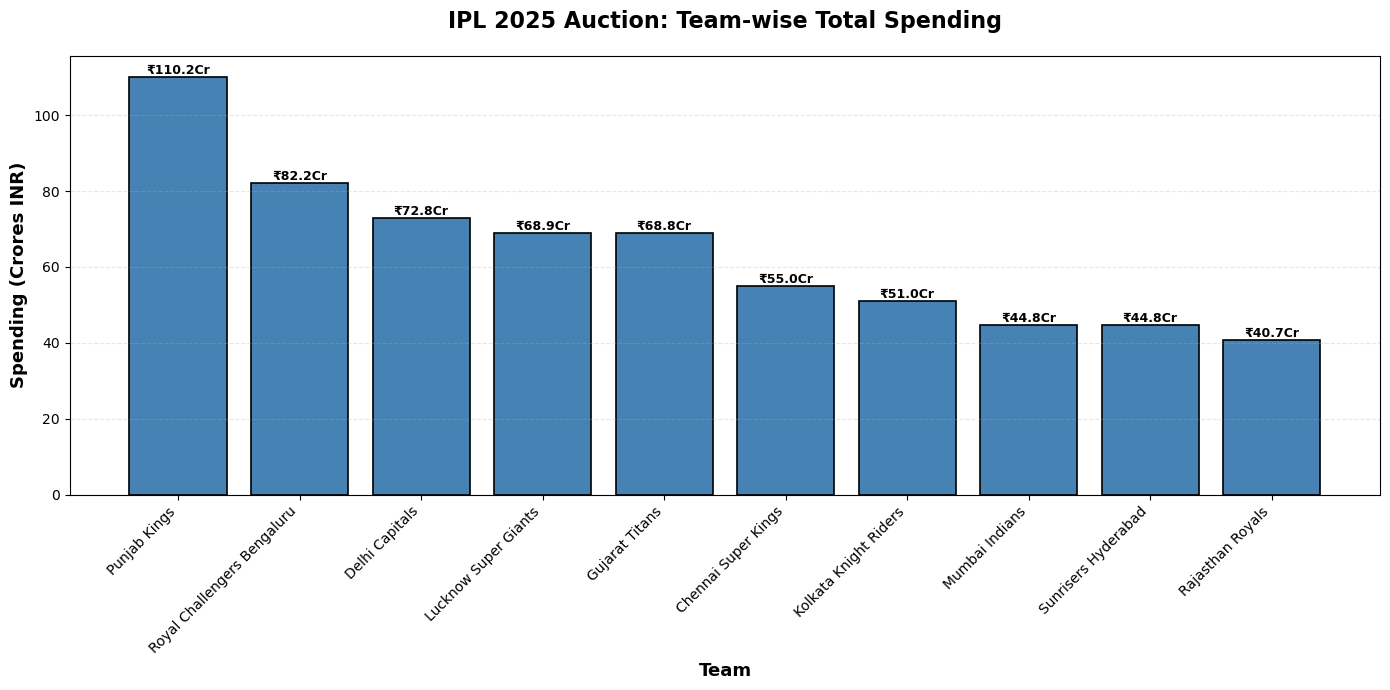

In [13]:
# Convert spending to crores for better readability
# 1 crore = 10,000,000 rupees
team_spend_crores = team_spend / 1e7

# Create bar chart
plt.figure(figsize=(14, 7))  # Set figure size

# Create bar plot
bars = plt.bar(range(len(team_spend_crores)), team_spend_crores.values,color='steelblue', edgecolor='black', linewidth=1.2)
plt.ylabel("Spending (Crores INR)", fontsize=13, fontweight='bold')
plt.xlabel("Team", fontsize=13, fontweight='bold')
plt.title("IPL 2025 Auction: Team-wise Total Spending", fontsize=16, fontweight="bold", pad=20)
plt.xticks(range(len(team_spend_crores)), team_spend_crores.index, rotation=45, ha="right",fontsize=10)

# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'₹{height:.1f}Cr',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()